# Metadrive Intro

We now introduce the environment we will be using for this notebook: [Metadrive](https://github.com/metadriverse/metadrive)

Check out the notebook [here](../quickstart.ipynb) for a quick introduction to Metadrive as well as how to install it.

Let's get started by doing a bunch of imports.

In [1]:
import gymnasium as gym
import typing
import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

We're going to be using MetaDrive's top-down view for this notebook, so we'll import that and register it.

In [2]:
from metadrive.envs.top_down_env import TopDownMetaDrive
gym.register(id="MetaDrive-topdown", entry_point=TopDownMetaDrive, kwargs=dict(config={}))

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


Let's test out the environment by creating an instance of it and taking a random action at each timestep.

In [3]:
# horizon represents the number of steps in an episode before truncation
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 100})
env.reset()
while True:
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    if terminated or truncated:
        break
env.close()

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment

## Gymnasium Environment

Metadrive uses the [Farama Gymnasium](https://gymnasium.farama.org/), which has a standard API for interacting with environments. There are a couple of functions and properties that are good to know about:
1. `reset()`: Resets the environment to its initial state and returns the initial observation.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.reset
2. `step(action)`: Takes an action and returns the next observation, the reward for taking the action, whether the episode is terminated, whether the episode is truncated (ran out of time), and any additional information.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.step
3. `close()`: Closes the environment.
    * Documentation: https://gymnasium.farama.org/api/env/#g1ymnasium.Env.close
4. `action_space`: The action space of the environment, which tells us the shape and bounds of the action space.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.action_space
5. `observation_space`: The observation space of the environment, which tells us the shape and bounds of the observation space.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.observation_space

Let's take a closer look at what our observation and action spaces are:

In [4]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 100})
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)
env.close()

Observation Space: Box(-0.0, 1.0, (84, 84, 5), float32)
Action Space: Box(-1.0, 1.0, (2,), float32)


Box spaces represent a continuous space. As the documentation states, a Box represents the Cartesian product of $n$ closed intervals.

For our observation space, we have a 84 by 84 pixel image with 5 channels, where each element is in the range $[0.0, 1.0]$.
* Documentation: https://metadrive-simulator.readthedocs.io/en/latest/observation.html

For the action space, we have a 2 dimensional vector, where each element is in the range $[-1.0, 1.0]$. The first element represents the steering angle, and the second element represents the throttle.
* Documentation: https://metadrive-simulator.readthedocs.io/en/latest/action_and_dynamics.html


# Implementation

Now that we've seen what the environment looks like, let's implement REINFORCE.

The REINFORCE algorithm is as follows:
1. Initialize the policy parameters $\theta$.
2. Create an initially empty set of trajectories $D$.
3. Create a trajectory $\tau = (s_1, a_1, r_1, \ldots, s_T, a_T, r_T)$ by running the policy $\pi_\theta$ in the environment and append it to $D$.
4. Compute the return $\hat{R}_t$ for each timestep $t$ in the trajectory.
5. Repeat steps 2-4 until $|D| = N$.
6. Compute the policy gradient estimate $\hat{g} = \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^{T_i} \nabla_\theta \log \pi_\theta(a_{i,t} | s_{i,t}) \hat{R}_t$.
7. Update the policy parameters $\theta \leftarrow \theta + \alpha \hat{g}$.
8. Repeat steps 2-7 until the policy converges.

All things considered, this is a pretty simple algorithm. Let's implement it!

## Discretization

There's one problem you might see here: we previously stated that we were focusing on the discrete case. This means our policy will produce discrete actions. However, our action space seems to be continuous.

How can we solve this problem?

Our solution is going to be to **discretize** our action space. This means that we will provide a finite number of actions, and each action corresponds to a fixed vector of real numbers.

We will discretize the steering angle into 2 bins, and the throttle into 2 bins. This will give us a total of 4 actions. We'll write a function to convert our discrete action into a continuous action, which we can provide to the environment.

In [5]:
NUM_ACTIONS = 5

def discrete2continuous(action:int) -> npt.NDArray[np.float32]:
    """
    Convert discrete action to continuous action
    """
    assert 0 <= action < NUM_ACTIONS
    throttle_magnitude = 1.0
    brake_magnitude = 1.0
    steering_magnitude = 1.0
    match action:
        case 0:
            return np.array([steering_magnitude, 0.0])
        case 1:
            return np.array([0.0, throttle_magnitude])
        case 2:
            return np.array([0.0, -brake_magnitude])
        case 3:
            return np.array([-steering_magnitude, 0.0])
        case 4:
            return np.array([0.0, 0.0])


## Collecting Trajectories

With this discretization function, we can write a function to collect a trajectory given a policy.

In [6]:
def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], int]) -> tuple[list[npt.NDArray], list[int], list[float]]:
    """
    Collect a trajectory from the environment using the given policy
    """
    observations = []
    actions = []
    rewards = []
    obs, info = env.reset()
    
    while True:
        observations.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(discrete2continuous(action))
        rewards.append(reward)
        if terminated or truncated:
            break

    return observations, actions, rewards

Note that we define a policy as any function that takes in an observation and returns an action. This means that we can be more general than just using a neural net as a policy.
For example, let's first test out our `collect_trajectory` function with a random policy:

In [7]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 100})
# horizon is the max number of steps in a trajectory
def random_policy(obs:npt.NDArray) -> int:
    """
    A random policy that returns a random action
    """
    return np.random.randint(0, NUM_ACTIONS)

obs, actions, rewards = collect_trajectory(env, random_policy)

# print the first 10 observations, actions, and rewards
print("Observations:", obs[:10])
print("Actions:", actions[:10])
print("Rewards:", rewards[:10])
env.close()

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: max step 


Observations: [array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]

## Reward-to-go (Contains Exercise)

Our `collect_trajectory` function allows us to gather rewards from the trajectory. However, recall that what we'll actually train the network on is the reward-to-go. Let's now create the function `reward_to_go` to compute the reward-to-go for each timestep in the trajectory.

In [8]:
def rewards_to_go(trajectory_rewards: list[float], gamma) -> list[float]:
    """
    Computes the gamma discounted reward-to-go for each state in the trajectory.
    """
    # TODO: Implement this function
    raise NotImplementedError()

## Policy Network (Contains Exercise)

So, now that we have a function that lets us go from policies to trajectories, we should work on creating a neural network based policy. The network should take in an observation, and return a probability for each number between 0 and 9.

We're going to keep the network fairly small for now.

In [9]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        #########################################################################################
        # TODO: Implement a Policy Network
        # Architecture:
        # Layer 1 - Convolutional Layer, kernel size 8, stride 4, output channels 16
        # Layer 2 - Convolutional Layer, kernel size 4, stride 2, output channels 32
        # Layer 3 - Fully Connected Layer, output size 256
        # Layer 4 - Fully Connected Layer, output size NUM_ACTIONS

        raise NotImplementedError()

        #########################################################################################

    def forward(self, x: torch.Tensor) -> torch.distributions.Categorical:
        #########################################################################################
        # TODO: Implement the forward pass of the Policy Network
        # Hint: Use logits when constructing the Categorical distribution

        raise NotImplementedError()
    
        #########################################################################################

There's one minor issue we have to resolve before we can use this network though: [PyTorch's Conv2d module](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) expects the input to be of shape $(N, C_{in}, H_{in}, W_{in})$, where $N$ is the batch size, $C_{in}$ is the number of channels, $H_{in}$ is the height, and $W_{in}$ is the width. However, our observation is of shape $(H_{in}, W_{in}, C_{in})$. We can fix this by adding a batch dimension and then using the [Permute](https://pytorch.org/docs/stable/generated/torch.permute.html) module. 

In [10]:
def obs_batch_to_tensor(obs: list[npt.NDArray[np.float32]], device: torch.device) -> torch.Tensor:
    """
    Reshape the image observation from (B, H, W, C) to (B, C, H, W) and convert it to a tensor
    """
    return torch.tensor(np.stack(obs), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

Let's define a policy function that allows us to sample an action:

In [11]:
def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

class NNPolicy:
    """
    A policy based on a neural network 
    """

    def __init__(self, net:PolicyNetwork):
        self.net = net

    def __call__(self, obs:npt.NDArray) -> int:
        # convert observation to a tensor
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            return self.net(obs_tensor).sample().item()

Let's test it out (untrained)

In [12]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 100})

# create a policy network
policy_network = PolicyNetwork()

# create a policy that samples from the policy network
policy = NNPolicy(policy_network)

# collect a trajectory using our untrained network
obs, actions, rewards = collect_trajectory(env, policy)

# print the first 10 observations, actions, and rewards
print("Observations:", obs[:10])
print("Actions:", actions[:10])
print("Rewards:", rewards[:10])

env.close()

# free up memory
del policy
del policy_network

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: max step 


Observations: [array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]

As you can see, it performs basically random actions, since it hasn't been trained yet.

## Computing the Policy Gradient (Contains Exercise)

Let's now work on the meat of the problem: computing the policy gradient

In [13]:
@dataclass
class PolicyGradientConfig:
    entropy_bonus: float

def compute_policy_gradient_loss(
    # Current policy network's probability of choosing an action
    # inner shape = (Batch, Action)
    pi_theta_given_st: torch.distributions.Categorical,
    # Which action was chosen
    # in (Batch,)
    a_t: torch.Tensor,
    # Rewards To Go for the chosen action
    # in (Batch,)
    R_t: torch.Tensor,
    # config
    config: PolicyGradientConfig,
) -> torch.Tensor:
    r"""
    Computes the policy gradient loss for a vector of examples, and reduces with mean.

    The standard policy gradient is given by the expected value over trajectories of:

    :math:`\sum_{t=0}^{T} \nabla_{\theta} (\log \pi_{\theta}(a_t|s_t))R_t`
    
    where:
    * :math:`\pi_{\theta}(a_t|s_t)` is the current policy's probability to perform action :math:`a_t` given :math:`s_t`
    * :math:`R_t` is the rewards-to-go from the state at time t to the end of the episode from which it came.
    """

    ################################################################################################
    # TODO: Implement the policy gradient loss
    # Hint: Recall that the policy gradient for a single transition (state-action pair) is given by:
    # $\nabla_{\theta} \log \pi_{\theta}(a_t|s_t)R_t$
    # However, it's easier to work with losses, rather than raw gradients.
    # Therefore we construct a loss, that when differentiated, gives us the policy gradient.
    # this loss is given by: $-\log \pi_{\theta}(a_t|s_t)R_t$
    # Hint: use the log_prob method of the Categorical distribution to get the log probability of the chosen action

    raise NotImplementedError()

    ################################################################################################


def train_policygradient(
    policy_network: PolicyNetwork,
    policy_optimizer: torch.optim.Optimizer,
    observation_batch: list[npt.NDArray],
    action_batch: list[int],
    rtg_batch: list[float],
    config: PolicyGradientConfig,
) -> float:
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(rtg_batch)

    # get device
    device = deviceof(policy_network)

    # convert data to tensors on correct device

    # in (Batch, C, H, W)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # in (Batch,)
    rtg_batch_tensor = torch.tensor(
        rtg_batch, dtype=torch.float32, device=device
    )

    # in (Batch,)
    chosen_action_tensor = torch.tensor(action_batch, dtype=torch.long, device=device)

    # train policy network
    policy_optimizer.zero_grad()
    action_probs = policy_network.forward(observation_batch_tensor)
    policy_loss = compute_policy_gradient_loss(
        action_probs, chosen_action_tensor, rtg_batch_tensor, config
    )
    policy_loss.backward()
    policy_optimizer.step()

    # return the respective losses
    return policy_loss.item()


## Training the Policy Network

With that, we're done. Let's train!

In [14]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.top_down_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [15]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_network = PolicyNetwork().to(device)

policy_optimizer = torch.optim.Adam(policy_network.parameters())

policy = NNPolicy(policy_network)

step = 0
returns = []
losses = []

In [16]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 100, "num_scenarios": 100})

This code takes a long time to run, but the low learning rate and high batch sizes are a necessity for training REINFORCE. You should leave this code running for about an hour. Don't be surprised if it takes a long time for rewards to creep over 3.0.

In [17]:
set_lr(policy_optimizer, 1e-4)
TRAIN_EPOCHS = 100
EPISODES_PER_BATCH = 32
GAMMA = 0.75
CONFIG = PolicyGradientConfig(entropy_bonus=0.10)

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[npt.NDArray[np.float32]] = []
    act_batch:list[int] = []
    rtg_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        obs_traj, act_traj, rew_traj = collect_trajectory(env, policy)
        rtg_traj = rewards_to_go(rew_traj, GAMMA)

        # Update batch
        obs_batch.extend(obs_traj)
        act_batch.extend(act_traj)
        rtg_batch.extend(rtg_traj)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    loss = train_policygradient(
        policy_network,
        policy_optimizer,
        obs_batch,
        act_batch,
        rtg_batch,
        CONFIG,
    )

    # collect statistics
    returns.append(trajectory_returns)
    losses.append(loss)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Policy Loss: {losses[-1]:.3f}")

    step += 1

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Step 0, Avg. Returns: 1.274 +/- 0.431, Median: 1.193, Policy Loss: -0.081
Step 1, Avg. Returns: 1.418 +/- 0.740, Median: 1.391, Policy Loss: -0.072
Step 2, Avg. Returns: 1.184 +/- 0.617, Median: 1.121, Policy Loss: -0.087
Step 3, Avg. Returns: 1.462 +/- 0.444, Median: 1.426, Policy Loss: -0.070
Step 4, Avg. Returns: 1.539 +/- 0.496, Median: 1.514, Policy Loss: -0.065
Step 5, Avg. Returns: 1.679 +/- 0.584, Median: 1.498, Policy Loss: -0.056
Step 6, Avg. Returns: 1.482 +/- 0.586, Median: 1.483, Policy Loss: -0.069
Step 7, Avg. Returns: 1.762 +/- 0.663, Median: 1.619, Policy Loss: -0.051
Step 8, Avg. Returns: 1.547 +/- 0.585, Median: 1.480, Policy Loss: -0.065
Step 9, Avg. Returns: 1.496 +/- 1.080, Median: 1.286, Policy Loss: -0.068
Step 10, Avg. Returns: 1.877 +/- 0.736, Median: 1.840, Policy Loss: -0.046
Step 11, Avg. Returns: 2.077 +/- 0.799, Median: 2.036, Policy Loss: -0.033
Step 12, Avg. Returns: 1.701 +/- 0.605, Median: 1.477, Policy Loss: -0.057
Step 13, Avg. Returns: 2.028 +/- 0.

In [18]:
env.close()

Let's visualize how the policy drives:

In [19]:
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})
obs, act, rew = collect_trajectory(env, policy)
env.close()

print("Reward:", sum(rew))

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 11.85472863635404


For us, we got returns of around 40-50 after training.

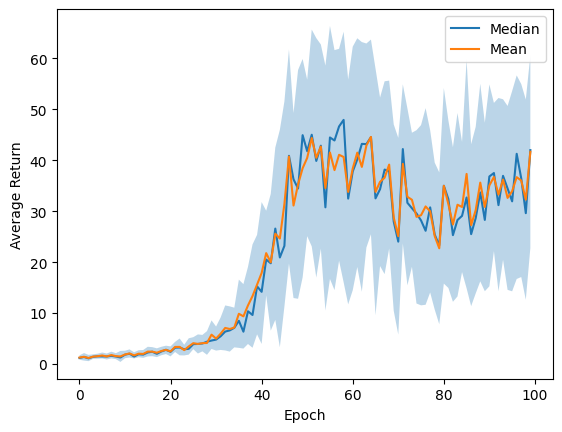

In [20]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_medians, label="Median")
plt.plot(return_means, label="Mean")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()